<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/clicktag/clicktag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Mon Jun 21 22:42:44 UTC 2021


In [2]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 518 (delta 74), reused 124 (delta 28), pack-reused 296
Receiving objects: 100% (518/518), 426.03 MiB | 28.42 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Checking out files: 100% (131/131), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 49kB/s 
     |████████████████████████████████| 133kB 35.1MB/s 
     |████████████████████████████████| 19.1MB 166kB/s 
     |████████████████████████████████| 10.3MB 19.0MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 112kB 53.5MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 32.1MB/s 


In [4]:
# extract everything
!ls /content/BMGP_2020/data/clicktag/kite/*.tar.gz |xargs -n1 tar -xvf


counts_filtered/
counts_filtered/cells_x_features.genes.txt
counts_filtered/adata.h5ad
counts_filtered/cells_x_features.barcodes.txt
counts_filtered/cells_x_features.mtx
counts_unfiltered/
counts_unfiltered/cells_x_features.genes.txt
counts_unfiltered/adata.h5ad
counts_unfiltered/cells_x_features.barcodes.txt
counts_unfiltered/cells_x_features.mtx


In [5]:
!tar -xvf /content/BMGP_2020/data/clicktag/citeseqcount/umi_count.tar.gz

umi_count/
umi_count/features.tsv.gz
umi_count/matrix.mtx.gz
umi_count/matrix.T.mtx.gz
umi_count/barcodes.tsv.gz


In [6]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

Looking in indexes: https://test.pypi.org/simple/


# Imports

In [7]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

metadata = {
    "kb": "#e41a1c",
    "cs": "#377eb8"
}
labels = list(metadata.keys())
colors = list(metadata.values())

In [8]:
raw_kb = anndata.read_h5ad("/content/counts_unfiltered/adata.h5ad")

In [9]:
raw_cs = import_matrix_as_anndata("/content/umi_count/matrix.T.mtx.gz", "/content/umi_count/barcodes.tsv.gz", "./umi_count/features.tsv.gz", t2g_path="/content/BMGP_2020/references/clicktag/kite/f2b.txt")
raw_cs.var.index = raw_cs.var.index.map(lambda x: x.split("-")[0])

In [10]:
filtered_bcs = pd.read_csv("counts_filtered/cells_x_features.barcodes.txt", header=None)
filtered_features = pd.read_csv("counts_filtered/cells_x_features.genes.txt", header=None)

In [11]:
# common = np.intersect1d(filtered_bcs.values, raw_cs.obs.index.values)
common = np.intersect1d(np.intersect1d(raw_kb.obs.index.values, raw_cs.obs.index.values), filtered_bcs.values)
common_features = np.intersect1d(filtered_features.values, raw_cs.var.index.values)

In [12]:
kb = raw_kb[raw_kb.obs.index.isin(common)][:,raw_kb.var.index.isin(common_features)]
cs = raw_cs[raw_cs.obs.index.isin(common)][:,raw_cs.var.index.isin(common_features)]

In [13]:
print(kb)
print(cs)

View of AnnData object with n_obs × n_vars = 3795 × 20
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 3795 × 20


In [14]:
print(False in (kb.obs.index.values == cs.obs.index.values))
print(False in (kb.var.index.values == cs.var.index.values))

True
False


In [15]:
kb = kb[kb.obs.sort_index().index]
cs = cs[cs.obs.sort_index().index]

kb = kb[:,kb.var.sort_index().index]
cs = cs[:,cs.var.sort_index().index]

In [16]:
print(True in (kb.obs.index.values != cs.obs.index.values))
print(True in (kb.var.index.values != cs.var.index.values))

False
False


This set of reads only corresponds to clicktags 1-8, so we keep those and drop the others

In [17]:
keep = ["ClickTag1","ClickTag2","ClickTag3","ClickTag4","ClickTag5","ClickTag6","ClickTag7","ClickTag8"]

kb = kb[:,kb.var.index.isin(keep)]
cs = cs[:,cs.var.index.isin(keep)]

In [44]:
kb.layers[0] = kb.X
kb.layers[1] = cs.X

In [45]:
kb.write_h5ad("clicktag.h5ad")

# Visualizations

## Knee

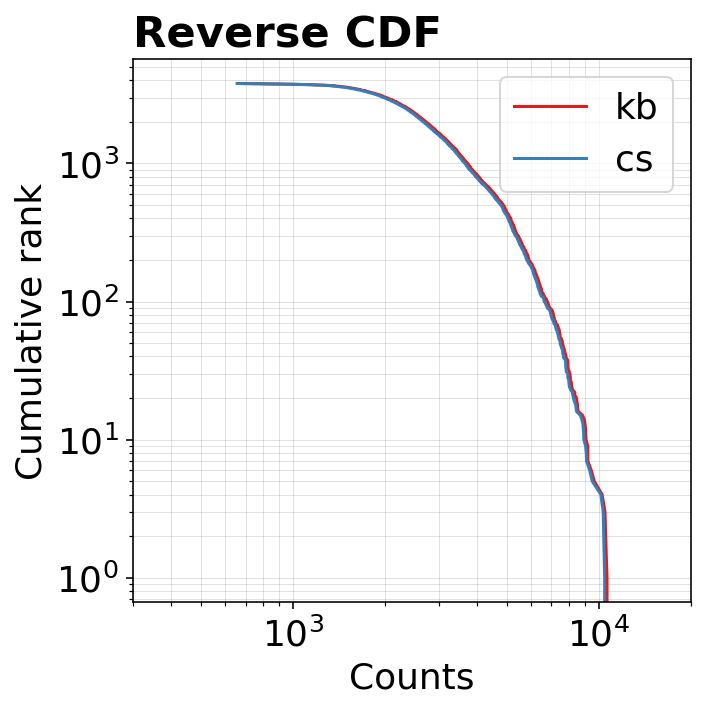

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cs.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)
fig.show()

## pseudobulk

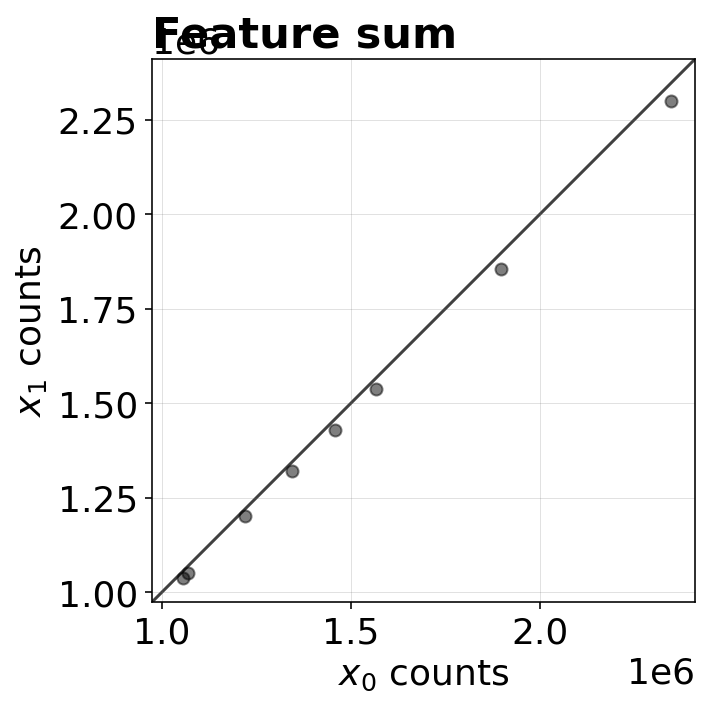

In [35]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cs.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="linear", yscale="linear")

fig.show()

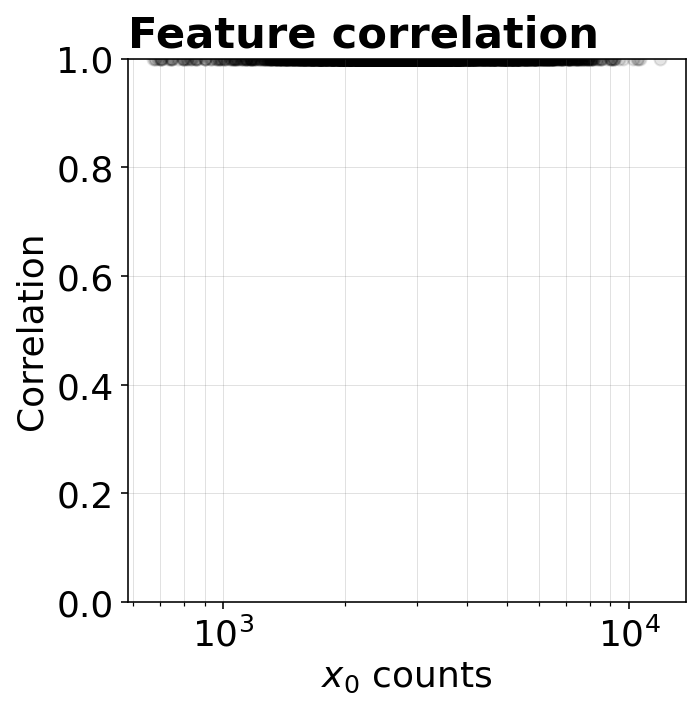

In [20]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cs.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [21]:
# note, taking log1p here
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cs.X))
YY_YX = compare.l1_distance(np.log1p(cs.X), np.log1p(kb.X))

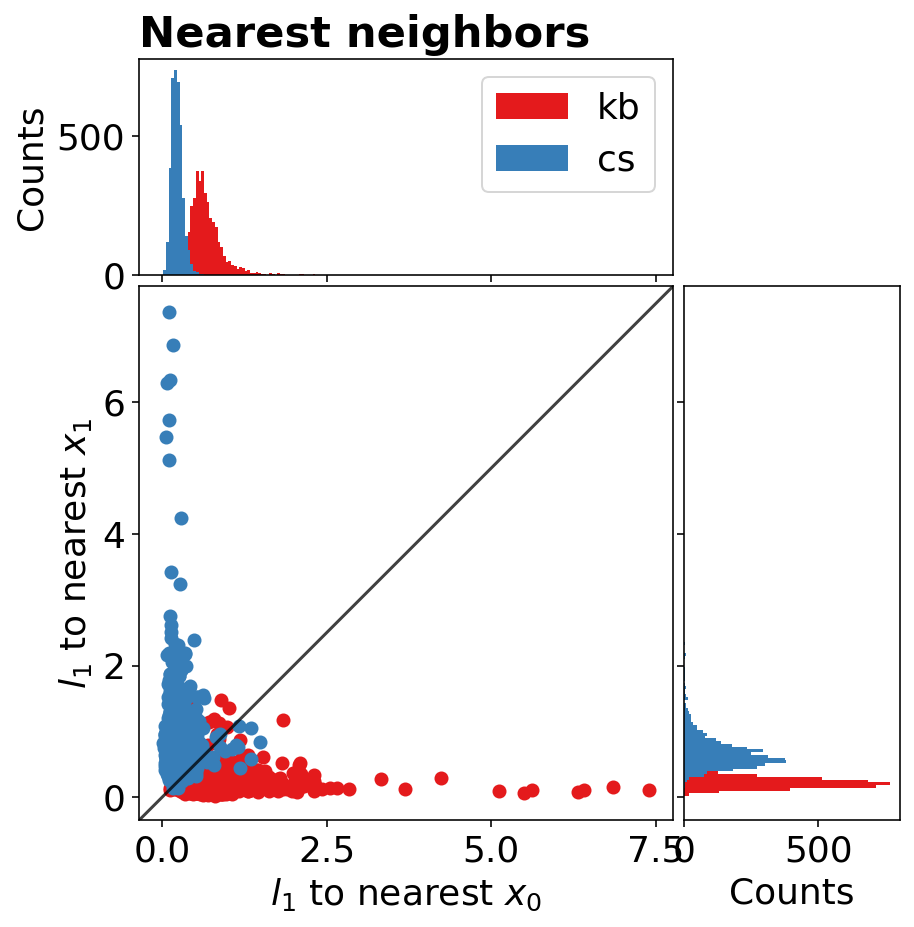

In [22]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [23]:
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

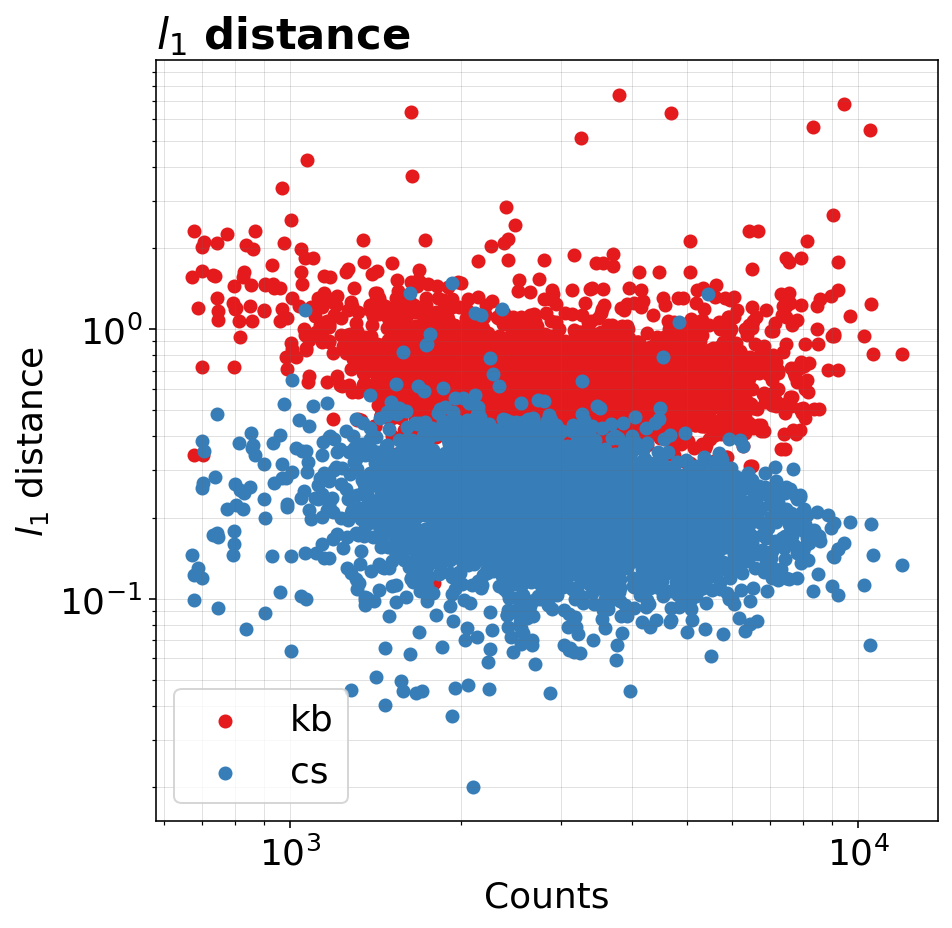

In [24]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)

fig.show()

----------------------------------------